In [1]:
# Librerias

import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

## 🛠️ Preparación de los Datos

In [2]:
# Carga de datos archivo tratado anteriormente
datos_telecom2 = pd.read_csv('/content/telecomXdata_limpio.csv')
datos_telecom2.head(5)

,customerid,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,charges_monthly,charges_total,daily_accounts
0,0002-ORFBO,0,female,0,1,1,9,1,no,dsl,...,0,1,1,0,one year,1,mailed check,65.6,593.30,2.19
1,0003-MKNFE,0,male,0,0,0,9,1,yes,dsl,...,0,0,0,1,month to month,0,mailed check,59.9,542.40,2.00
2,0004-TLHLJ,1,male,0,0,0,4,1,no,fiber optic,...,1,0,0,0,month to month,1,electronic check,73.9,280.85,2.46
3,0011-IGKFF,1,male,1,1,0,13,1,no,fiber optic,...,1,0,1,1,month to month,1,electronic check,98.0,1237.85,3.27
4,0013-EXCHZ,1,female,1,1,0,3,1,no,fiber optic,...,0,1,1,0,month to month,1,mailed check,83.9,267.40,2.80


### Eliminacion de columnas irrelevantes

Se eliminaran las siguientes columnas del conjunto de datos tratados anteriormente, ya que a mi criterio no aportan valor al analisis o a los modelos predictivos:

-customerid           
-gender            
-partner          
-multiplelines
-onlinesecurity    
-onlinebackup         
-deviceprotection  
-techsupport       
-streamingtv        
-streamingmovies  
-paperlessbilling     
-paymentmethod    
-charges_total     
-daily_accounts

In [3]:
#Eliminacion de columnas
columnas_a_eliminar = [
    'customerid', 'gender', 'partner', 'multiplelines',
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies',
    'paperlessbilling', 'paymentmethod', 'charges_total',
    'daily_accounts'
]

datos_telecom2 = datos_telecom2.drop(columns=columnas_a_eliminar)
datos_telecom2.head(5)

,churn,seniorcitizen,dependents,tenure,phoneservice,internetservice,contract,charges_monthly
0,0,0,1,9,1,dsl,one year,65.6
1,0,0,0,9,1,dsl,month to month,59.9
2,1,0,0,4,1,fiber optic,month to month,73.9
3,1,1,0,13,1,fiber optic,month to month,98.0
4,1,1,0,3,1,fiber optic,month to month,83.9


In [4]:
datos_telecom2.columns

Index(['churn', 'seniorcitizen', 'dependents', 'tenure', 'phoneservice',
       'internetservice', 'contract', 'charges_monthly'],
      dtype='object')

### Encoding

In [5]:
datos_telecom2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   churn            7043 non-null   int64  
 1   seniorcitizen    7043 non-null   int64  
 2   dependents       7043 non-null   int64  
 3   tenure           7043 non-null   int64  
 4   phoneservice     7043 non-null   int64  
 5   internetservice  7043 non-null   object 
 6   contract         7043 non-null   object 
 7   charges_monthly  7043 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 440.3+ KB


Para este analisis, vamos a aplicar onehotencoding a las variables explicativas



In [6]:
# separacion de variables explicativas y de respuesta

X = datos_telecom2.drop('churn', axis=1)  #explicativas
y = datos_telecom2['churn']   #respuesta

In [7]:
X

,seniorcitizen,dependents,tenure,phoneservice,internetservice,contract,charges_monthly
0,0,1,9,1,dsl,one year,65.60
1,0,0,9,1,dsl,month to month,59.90
2,0,0,4,1,fiber optic,month to month,73.90
3,1,0,13,1,fiber optic,month to month,98.00
4,1,0,3,1,fiber optic,month to month,83.90
...,...,...,...,...,...,...,...
7038,0,0,13,1,dsl,one year,55.15
7039,0,0,22,1,fiber optic,month to month,85.10
7040,0,0,2,1,dsl,month to month,50.30
7041,0,1,67,1,dsl,two year,67.85


In [8]:
y

,churn
0,0
1,0
2,1
3,1
4,1
...,...
7038,0
7039,1
7040,0
7041,0


Se transfroman las variables explicativas

In [9]:
columnas = X.columns

In [10]:
# se crea el transformador
one_hot = make_column_transformer((OneHotEncoder(drop='if_binary', sparse_output=False),
                                  ['internetservice', 'contract']),
                                  remainder='passthrough')

In [11]:
# Aplico el modelo - transformacion
X = one_hot.fit_transform(X)

In [12]:
one_hot.get_feature_names_out(columnas)

array(['onehotencoder__internetservice_dsl',
       'onehotencoder__internetservice_fiber optic',
       'onehotencoder__internetservice_no',
       'onehotencoder__contract_month to month',
       'onehotencoder__contract_one year',
       'onehotencoder__contract_two year', 'remainder__seniorcitizen',
       'remainder__dependents', 'remainder__tenure',
       'remainder__phoneservice', 'remainder__charges_monthly'],
      dtype=object)

In [13]:
X_df = pd.DataFrame(X, columns=one_hot.get_feature_names_out(columnas))  #convierto en dataframe para mejor visualizacion
X_df.columns = X_df.columns.str.replace('^onehotencoder__', '', regex=True) #arreglo los nombres
X_df.columns = X_df.columns.str.replace('^remainder__', '', regex=True)

#nombre de columnas estandarizados
X_df.columns = (
    X_df.columns.str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace(r'__+', '_', regex=True)
               .str.replace(r'[^a-z0-9_]', '', regex=True)
)

X_df

,internetservice_dsl,internetservice_fiber_optic,internetservice_no,contract_month_to_month,contract_one_year,contract_two_year,seniorcitizen,dependents,tenure,phoneservice,charges_monthly
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9.0,1.0,65.60
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,1.0,59.90
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,73.90
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,13.0,1.0,98.00
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,83.90
...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0,1.0,55.15
7039,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,1.0,85.10
7040,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,50.30
7041,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,67.0,1.0,67.85


La variable respuesta y (churn esta en series pandasy es binaria) no hace falta normalizarla

## Verificación de la Proporción de Cancelación (Churn)

In [14]:
proporciones = y.value_counts(normalize=True)  # calculo proporciones
print(proporciones)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


segun lo anterior podemos ver que hay un desvalance de clases, en este caso es un desbalanceo moderado, asi que no hare Balanceo de clases.

Nota: No asumir clases balanceadas

## 🎯 Correlación y Selección de Variables

### Análisis de Correlación

In [15]:
#uno de X_df y y para generar la matriz de correlacion
df_correlacion = X_df.copy()
df_correlacion['churn'] = y.values

In [16]:
# calculo correlacion
matriz_correlacion = df_correlacion.corr()
matriz_correlacion

,internetservice_dsl,internetservice_fiber_optic,internetservice_no,contract_month_to_month,contract_one_year,contract_two_year,seniorcitizen,dependents,tenure,phoneservice,charges_monthly,churn
internetservice_dsl,1.000000,-0.640987,-0.380635,-0.065509,0.046795,0.031714,-0.108322,0.052010,0.013274,-0.452425,-0.160189,-0.124214
internetservice_fiber_optic,-0.640987,1.000000,-0.465793,0.244164,-0.076324,-0.211526,0.255338,-0.165818,0.019720,0.289999,0.787066,0.308020
internetservice_no,-0.380635,-0.465793,1.000000,-0.218639,0.038004,0.218278,-0.182742,0.139812,-0.039062,0.172209,-0.763557,-0.227890
contract_month_to_month,-0.065509,0.244164,-0.218639,1.000000,-0.568744,-0.622633,0.138360,-0.231720,-0.645561,-0.000742,0.060165,0.405103
contract_one_year,0.046795,-0.076324,0.038004,-0.568744,1.000000,-0.289510,-0.046262,0.068368,0.202570,-0.002791,0.004904,-0.177820
contract_two_year,0.031714,-0.211526,0.218278,-0.622633,-0.289510,1.000000,-0.117000,0.204613,0.558533,0.003519,-0.074681,-0.302253
seniorcitizen,-0.108322,0.255338,-0.182742,0.138360,-0.046262,-0.117000,1.000000,-0.211185,0.016567,0.008576,0.220173,0.150889
dependents,0.052010,-0.165818,0.139812,-0.231720,0.068368,0.204613,-0.211185,1.000000,0.159712,-0.001762,-0.113890,-0.164221
tenure,0.013274,0.019720,-0.039062,-0.645561,0.202570,0.558533,0.016567,0.159712,1.000000,0.008448,0.247900,-0.352229
phoneservice,-0.452425,0.289999,0.172209,-0.000742,-0.002791,0.003519,0.008576,-0.001762,0.008448,1.000000,0.247398,0.011942


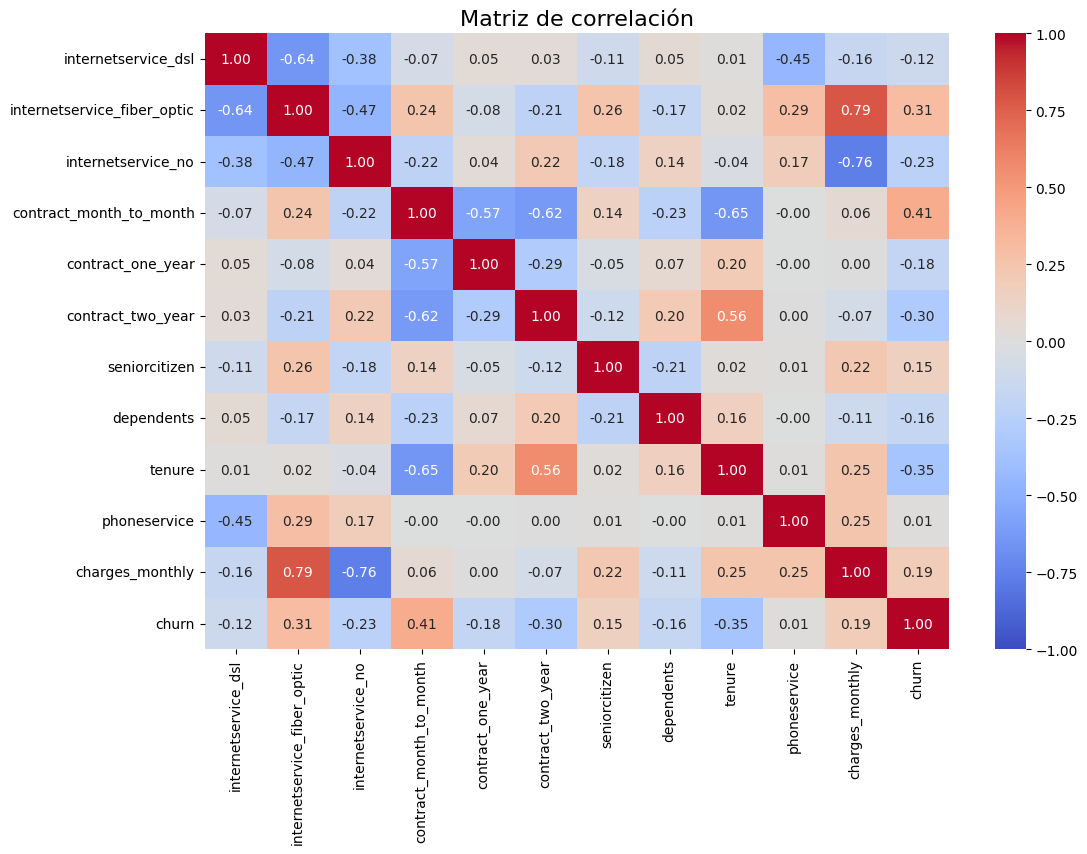

In [17]:
grafica_matriz_correlacion = df_correlacion.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(grafica_matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de correlación', fontsize=16)
plt.show()

In [18]:
matriz_correlacion['churn']

,churn
internetservice_dsl,-0.124214
internetservice_fiber_optic,0.308020
internetservice_no,-0.227890
contract_month_to_month,0.405103
contract_one_year,-0.177820
contract_two_year,-0.302253
seniorcitizen,0.150889
dependents,-0.164221
tenure,-0.352229
phoneservice,0.011942


Según los resultados de la matriz de correlación, para los modelos elegiré las variables que presentan una correlación mayor a 0.30 con la cancelación (churn):

- contract_month_to_month

- tenure

- contract_two_year

- internetservice_fiber_optic

## Análisis Dirigido

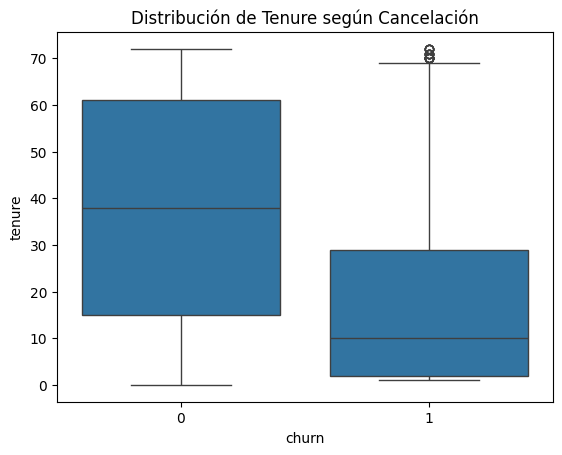

In [19]:
sns.boxplot(x='churn', y='tenure', data=df_correlacion)  #grafico tenure segun cancelacion
plt.title('Distribución de Tenure según Cancelación')
plt.show()

## 🤖 Modelado Predictivo

### Separación de Datos

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

### Creación de Modelos

Anteriormente no se realizo una Normalizacion a los datos, es decir que para la creacion de los modelos, tendre presente cuatro modelos que no son sensibles a la escala

- Árbol de Decisión

- Random Forest

- XGBoost

- Gradient Boosting

Seleccioné dos modelos no sensibles a la escala de los datos: Árbol de Decisión y Random Forest.
Ambos modelos se basan en divisiones recursivas de los datos en lugar de distancias o magnitudes, por lo que no requieren normalización.
El Árbol de Decisión es útil para interpretar reglas y umbrales, mientras que el Random Forest, al combinar múltiples árboles, reduce el riesgo de sobreajuste y suele obtener un mejor rendimiento.

In [21]:
# Modelo Arbol de decision

modelo_arbol = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced')  #uso el balanceo de clases para evitar sesgos
modelo_arbol.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)

In [22]:
modelo_arbol.score(X_test, y_test)

0.7444996451383961

Significa que el modelo clasifica correctamente el churn/no churn en el 71.96% de los casos.  aparentemente

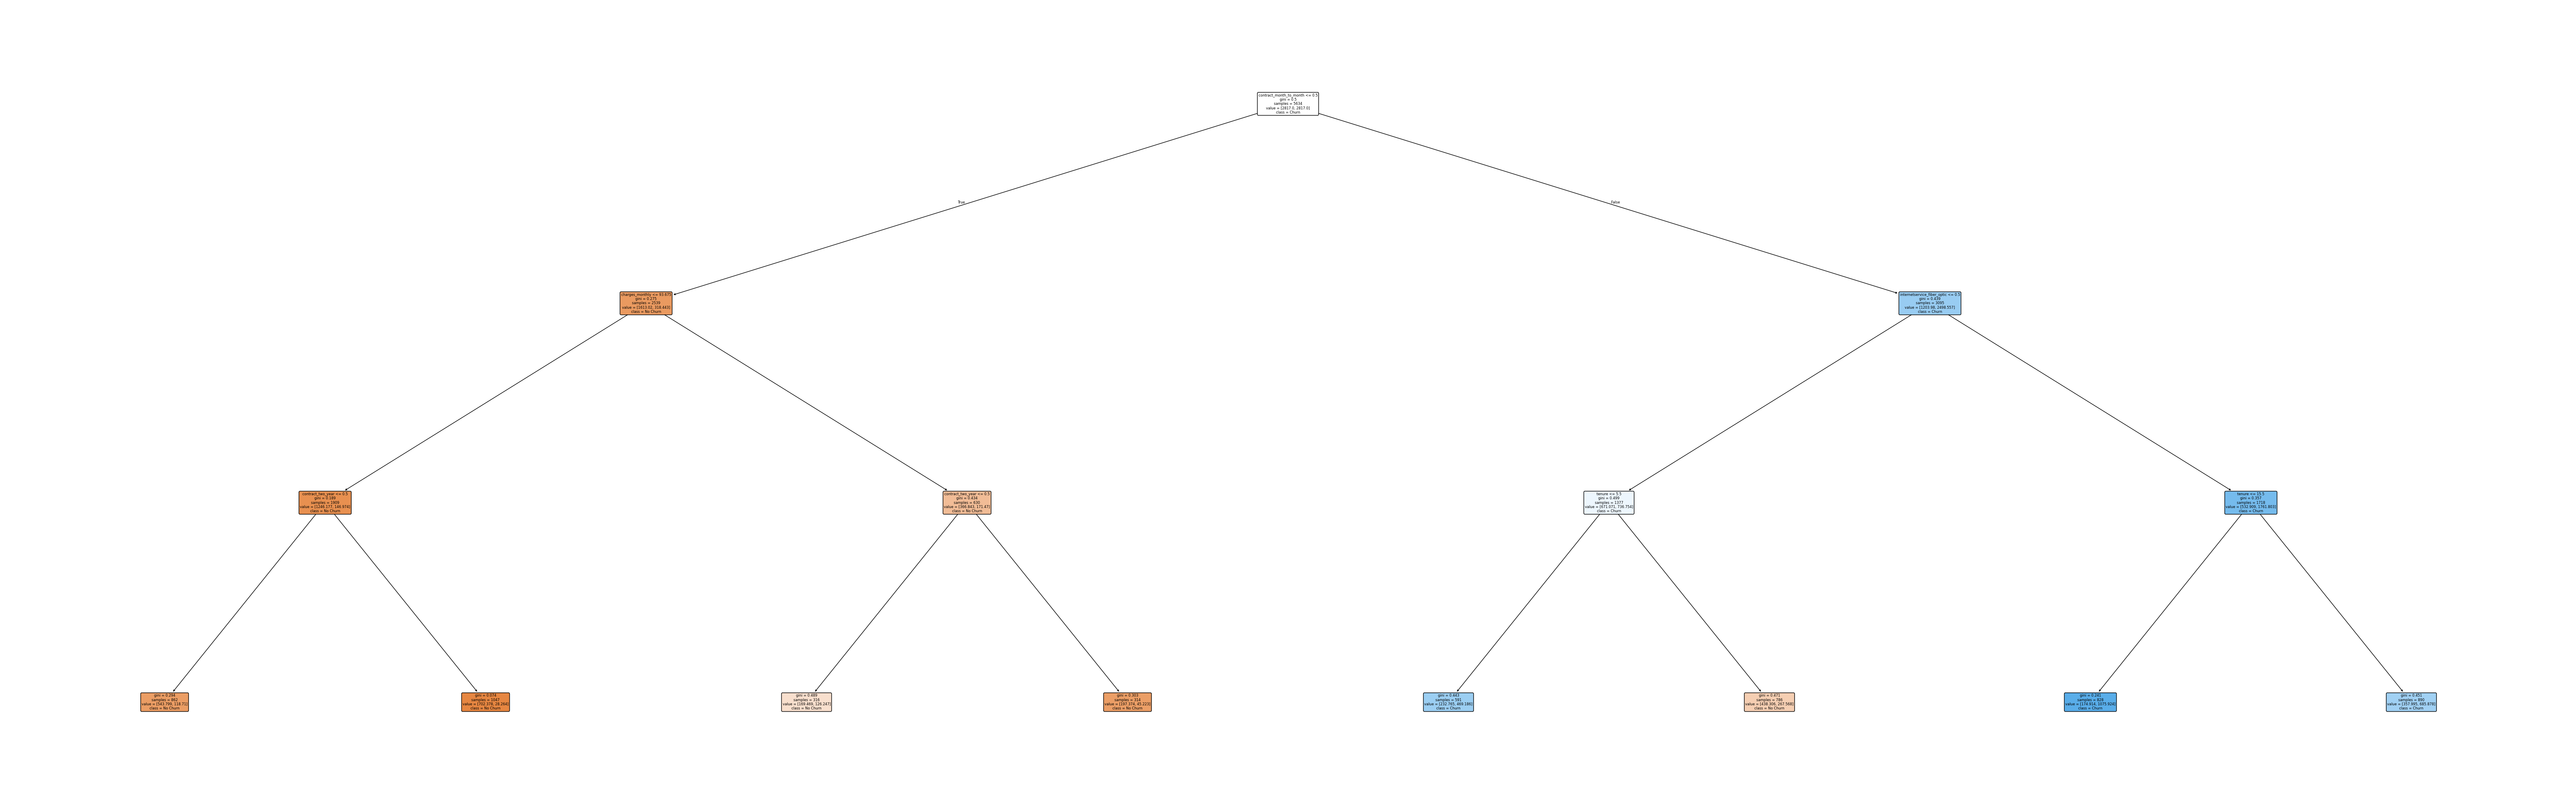

In [23]:
# Graficamos arbol de desiciones

plt.figure(figsize=(80,25))
plot_tree(
    modelo_arbol,
    feature_names=X_df.columns,     # nombres de las columnas de entrada
    class_names=['No Churn', 'Churn'], # nombres de las clases
    filled=True,                 # rellena colores
    rounded=True,                # esquinas redondeadas
    fontsize=6
)
plt.show()

In [24]:
modelo_arbol.score(X_train, y_train)  #reviso puntaje en entrenamiento

0.7451189208377706

La diferencia entre train y test es mínima, no parece tener sobre ajuste, aplicar max_depth ayuda a que el modelo generalice bien.

EVALUANDO EL MODELO 1.

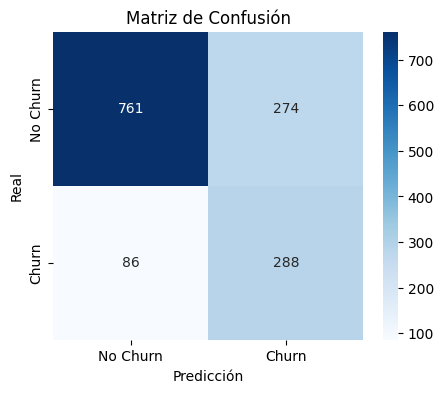

Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.81      1035
       Churn       0.51      0.77      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [25]:
# Predicciones en el conjunto de prueba
y_pred = modelo_arbol.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Precision, Recall y F1-score
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

Ligero underfitting. La restricción max_depth=3 simplifica demasiado el modelo y limita su capacidad de capturar patrones complejos.

## MODELO 2


Usare para mi segundo modelo - Random Forest

In [26]:
modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

modelo_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

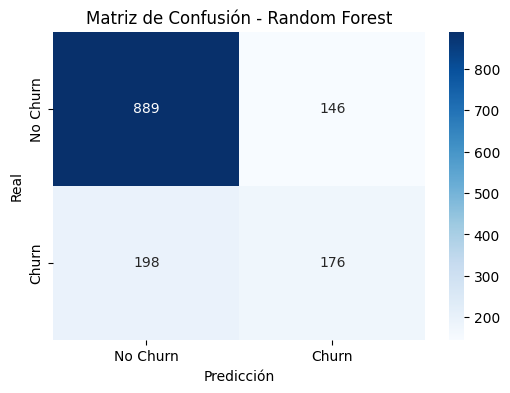


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1035
           1       0.55      0.47      0.51       374

    accuracy                           0.76      1409
   macro avg       0.68      0.66      0.67      1409
weighted avg       0.75      0.76      0.75      1409



In [27]:
y_pred_rf = modelo_rf.predict(X_test)

# Matriz de confusión
cm2 = confusion_matrix(y_test, y_pred_rf)

# Graficar la matriz
plt.figure(figsize=(6,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

para tener una presicion mas aecuada, hago ajustes a los hiper parametros de randomforest para intentar mantener la precisión pero subir el recall en churn.

In [28]:
# Definir el modelo base
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Definir la grilla de parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar la búsqueda
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',   # optimizamos recall para la clase positiva (churn)
    cv=3,               # validación cruzada
    n_jobs=-1           # usar todos los núcleos disponibles
)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_search.best_estimator_

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar en test
y_pred_best = best_rf.predict(X_test)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_best))

Mejores parámetros encontrados:
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



En el Random Forest básico, el modelo logró una precisión mayor en la clase Churn (0.55) pero con un recall relativamente bajo (0.47), lo que significa que acertaba más cuando predecía que un cliente se iría, pero dejaba escapar más de la mitad de los casos reales de cancelación. En cambio, el Random Forest ajustado priorizó el recall, elevándolo a 0.80, lo que le permitió identificar a la mayoría de los clientes que efectivamente se irían, aunque a costa de bajar la precisión a 0.50 y generar más falsos positivos. Por lo tanto, el modelo básico es más preciso en predecir Churn, pero el ajustado es más sensible y detecta más casos reales, lo que lo hace más útil si la meta es minimizar el número de cancelaciones no detectadas.

## 📋 Análisis de la Importancia de las Variables

El análisis de las variables se realizará utilizando el modelo final desarrollado en este ejercicio, Random Forest, ya que este algoritmo ofrece un método directo para calcular la importancia de las variables. La importancia se determina evaluando cuánto contribuye cada variable a la reducción de la impureza en las divisiones realizadas por los árboles que conforman el modelo.

                       Variable  Importancia
3       contract_month_to_month     0.299257
8                        tenure     0.195971
5             contract_two_year     0.149955
1   internetservice_fiber_optic     0.127589
10              charges_monthly     0.086322
2            internetservice_no     0.051851
4             contract_one_year     0.043217
0           internetservice_dsl     0.022975
7                    dependents     0.009642
6                 seniorcitizen     0.007322
9                  phoneservice     0.005898


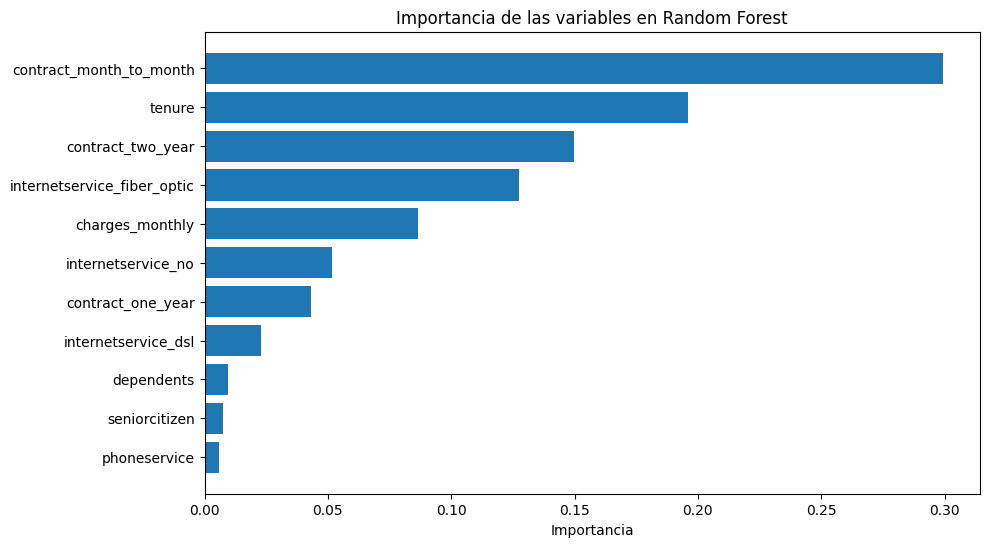

In [29]:
# Importancia de las variables
importancias = best_rf.feature_importances_

# Crear DataFrame ordenado
df_importancias = pd.DataFrame({
    'Variable': X_df.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar tabla
print(df_importancias)

# Gráfico de barras
plt.figure(figsize=(10,6))
plt.barh(df_importancias['Variable'], df_importancias['Importancia'])
plt.gca().invert_yaxis()  # La variable más importante arriba
plt.xlabel('Importancia')
plt.title('Importancia de las variables en Random Forest')
plt.show()

###  partir del analisis anterior podemos observar que:


- contract_month_to_month (29.9%): Es la variable más influyente con diferencia. Los clientes con contrato mes a mes parecen tener un riesgo mucho mayor de cancelar, algo que suele ser cierto en la práctica porque tienen menos compromiso.

- tenure (19.6%): El tiempo que llevan como clientes pesa mucho. Clientes con poco tiempo de permanencia tienden a tener mayor churn.

- contract_two_year (15.0%): Contratos largos están asociados con menor probabilidad de cancelación.

- internetservice_fiber_optic (12.8%): Tipo de servicio de internet también tiene un peso importante; quizá la experiencia o el precio del servicio influye.

- charges_monthly (8.6%): El costo mensual tiene un impacto, pero no tan fuerte como los contratos o la antigüedad.


  El resto de variables (como tener dependientes, ser senior citizen o phone service) tienen un peso pequeño, lo que indica que su aporte al modelo es marginal.

## 📋 Conclusión

Se entrenaron y evaluaron dos modelos predictivos para estimar la probabilidad de cancelación de clientes: Árbol de Decisión y Random Forest.

- Arbol de Decisión alcanzó una precisión del 74%, con una precisión (precision) del 90% para clientes que no cancelan y 51% para clientes que cancelan. Su f1-score promedio ponderado fue de 0.76.

- Random Forest también obtuvo una precisión del 74%, pero con ligeras mejoras en la capacidad de identificar clientes que cancelan (recall del 80% frente al 77% del Árbol de Decisión). Su f1-score promedio ponderado fue de 0.75.

Aunque la precisión global es igual en ambos modelos, el Random Forest presentó un mejor balance entre precisión y recall para la clase de cancelación, lo que indica una mayor capacidad de generalización en este contexto.

## Según la importancia de las variables en el mejor modelo, los factores más determinantes son:

###Tipo de contrato:

contract_month_to_month (29.9% de importancia)

Los contratos mensuales presentan mayor probabilidad de cancelación debido a la baja barrera de salida.

### Tiempo total con la compañía (tenure) – 19.6%

Clientes con menor antigüedad tienden a cancelar antes, lo que sugiere que la etapa inicial de la relación es crítica.

### Contratos a largo plazo (contract_two_year – 14.9%)

Reducen el riesgo de cancelación, ya que implican compromiso contractual.

### Tipo de servicio de Internet (internetservice_fiber_optic – 12.7%)

Puede estar asociado a problemas de servicio, precios más altos o expectativas más altas que no se cumplen.

###Variables con menor influencia

dependents, seniorcitizen, phoneservice tienen poca relevancia en la predicción, por lo que no son prioritarias para estrategias de retención.

## Estrategias de retencion recomendadas



A partir de estos resultados, se sugieren las siguientes acciones:

- Fortalecer los beneficios de contratos a largo plazo
Ofrecer descuentos, beneficios exclusivos o acumulación de puntos para incentivar la migración de contratos mensuales a anuales o bianuales.

- Programas de onboarding para nuevos clientes
Implementar un plan de acompañamiento durante los primeros 3 a 6 meses para mejorar la experiencia y reducir cancelaciones tempranas.

- Revisión de planes y precios para clientes de fibra óptica
Evaluar si el costo y la calidad percibida están alineados con la competencia y realizar ajustes o compensaciones cuando sea necesario.

- Alertas tempranas de cancelación
Detectar clientes con bajo tenure y contrato mensual para ofrecerles promociones o contacto proactivo